In [1]:
import os
import sys

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

import pandas_datareader.data as web
import numpy as np
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Linux x86_64

3.5.5 |Anaconda, Inc.| (default, May 13 2018, 21:12:35) 
[GCC 7.2.0]


In [2]:
import fix_yahoo_finance as yf
import datetime
end = '2015-01-01'
start = '2007-01-01'
symbols = ['SPY','AAPL','MSFT']

 

In [3]:
get_px = lambda x: yf.download(x, start = start, end=end)['Adj Close']



data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
lrets = np.log(data/data.shift(1)).dropna()


[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [4]:
lrets.head()

,AAPL,MSFT,SPY
Date,,,
2007-01-04,0.021953,-0.001676,0.002120
2007-01-05,-0.007147,-0.005719,-0.008008
2007-01-08,0.004926,0.009737,0.004614
2007-01-09,0.079800,0.001002,-0.000850
2007-01-10,0.046746,-0.010064,0.003326


# Stationarity

What is stationarity ?

- Mean is not a function of time : (Trend) $\mathbb{E}[x]$ = μ  
   
- Variance is not a function of time (Heteroskedasticity) $\mathbb{Var}[x]$ = $\sigma^2$ 
    
- Covariance of the process does not change over time: $Cov(X_{t+1},X_t)$= f(h)

In [5]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

### Analyzing white noise

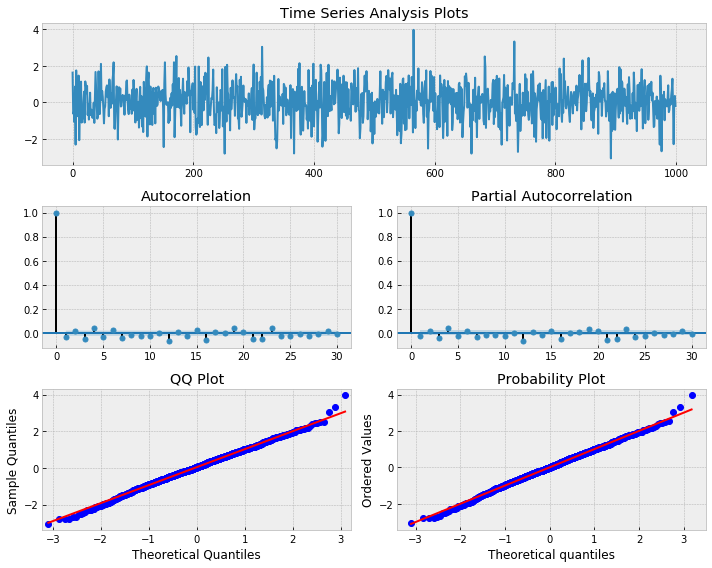

In [6]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [7]:
p("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


### Random Walk without a drift

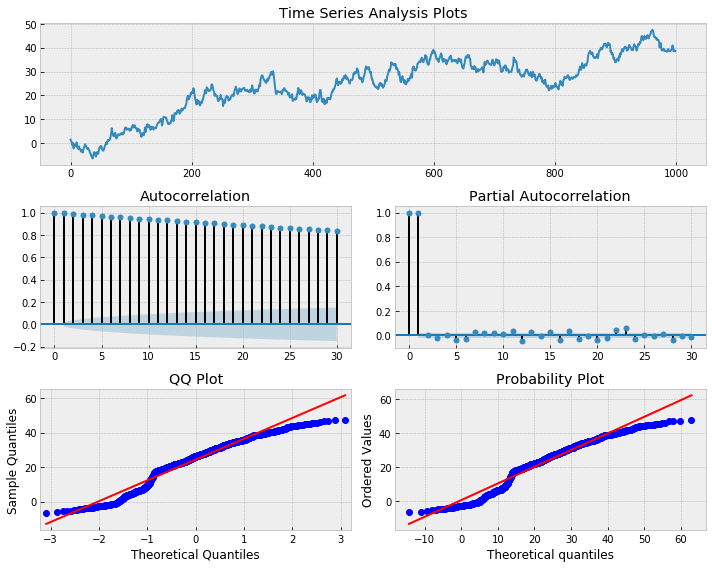

In [8]:
np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

### First difference of simulated Random Walk series

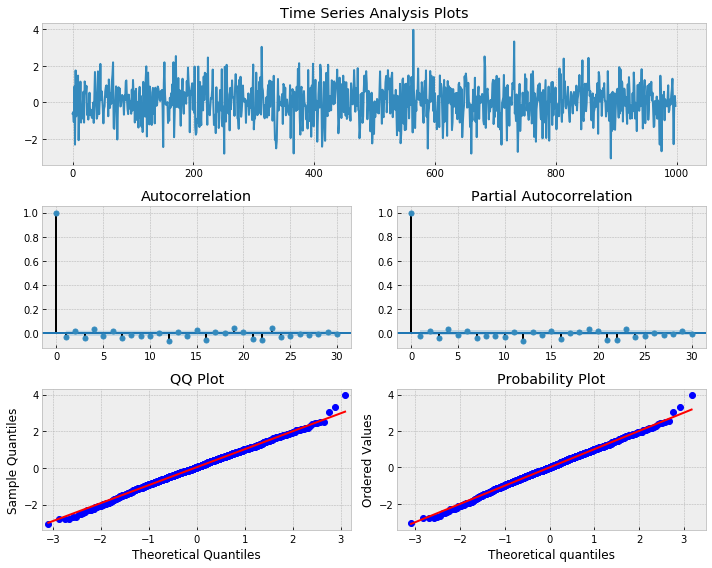

In [9]:
_ = tsplot(np.diff(x), lags=30)

### First difference of SPY prices

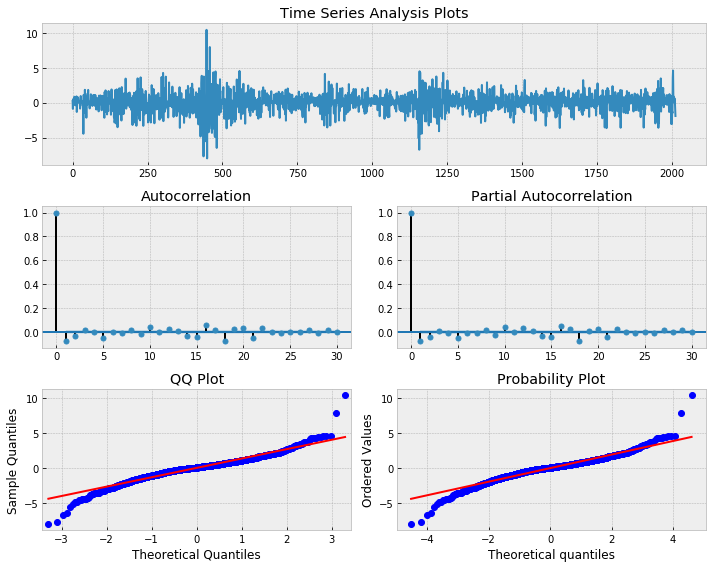

In [10]:
_ = tsplot(np.diff(data.SPY), lags=30)

# AR(p) process

AR(p) process is a time series regression given by 

$y(t) = α_1 y(t-1) + α_2 y(t-2) +  .... + α_{t-p}  y(t-p) + ω_t$

### Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

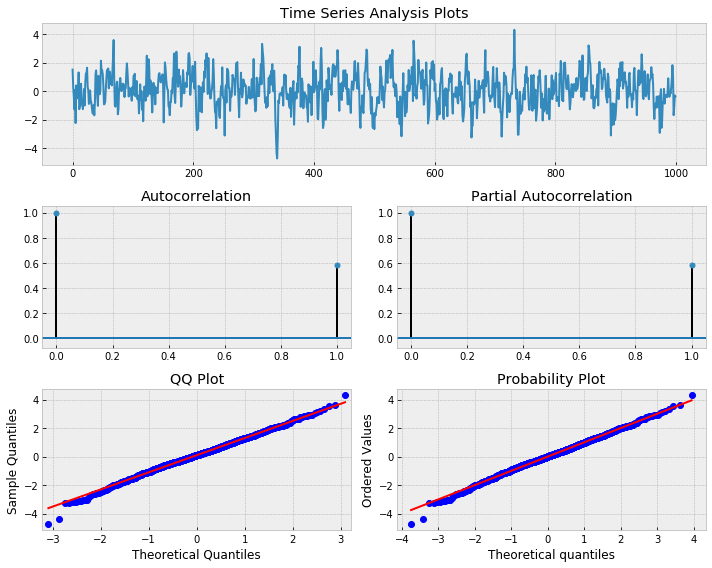

In [11]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=1)

In [12]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'.format(a, true_order))

CPU times: user 44.2 s, sys: 1.98 s, total: 46.1 s
Wall time: 11.6 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


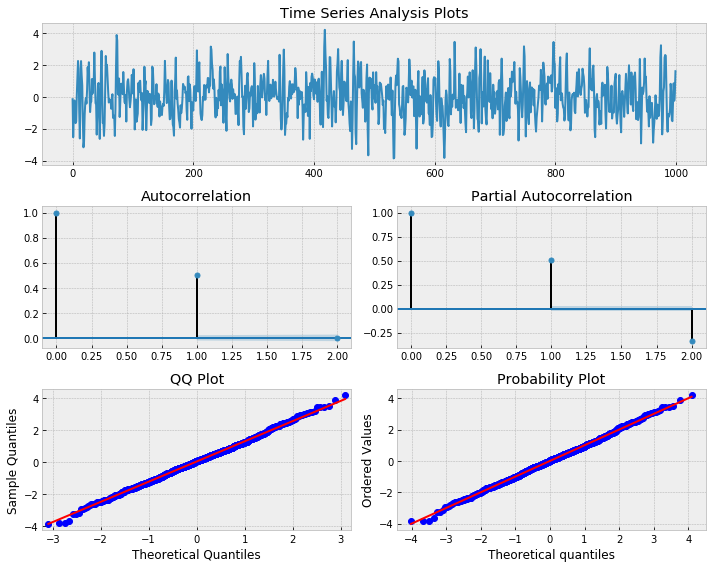

In [13]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=2)

In [14]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


# On Microsoft

In [15]:
# Select best lag order for MSFT returns

max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

best estimated lag order = 23


# Moving Average Models - MA(q)

MA(q) model is a linear combination of past white noise error terms as opposed to a linear combo of past observations like the AR(p) model. 

$x(t) = ω_t + \sum_{i=1}^P β_i ω_{t-i}$

                              ARMA Model Results                              
Dep. Variable:                   MSFT   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5218.848
Method:                           mle   S.D. of innovations              0.018
Date:                Tue, 09 Oct 2018   AIC                         -10429.695
Time:                        13:13:38   BIC                         -10407.266
Sample:                             0   HQIC                        -10421.462
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.MSFT    -0.0718      0.022     -3.213      0.001      -0.116      -0.028
ma.L2.MSFT    -0.0662      0.024     -2.773      0.006      -0.113      -0.019
ma.L3.MSFT     0.0321      0.022      1.434      0.1

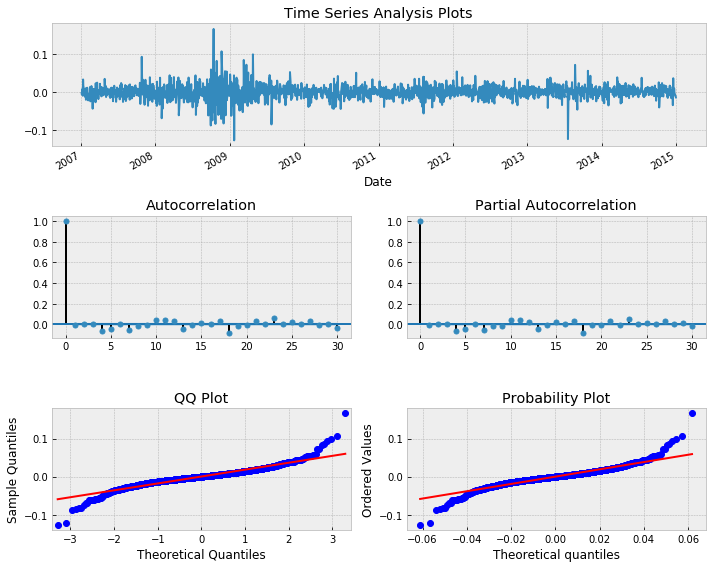

In [16]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.MSFT
mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

# Autoregressive Moving Average Models - ARMA(p, q)

In [17]:
# Fit ARMA model to MSFT returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets.MSFT, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: -10441.16050 | order: (4, 4)


                              ARMA Model Results                              
Dep. Variable:                   MSFT   No. Observations:                 2013
Model:                     ARMA(4, 4)   Log Likelihood                5229.580
Method:                           mle   S.D. of innovations              0.018
Date:                Tue, 09 Oct 2018   AIC                         -10441.160
Time:                        13:13:46   BIC                         -10390.694
Sample:                             0   HQIC                        -10422.636
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.MSFT     0.8472      0.187      4.527      0.000       0.480       1.214
ar.L2.MSFT    -0.0362      0.214     -0.169      0.866      -0.455       0.383
ar.L3.MSFT     0.1288      0.227      0.568      0.5

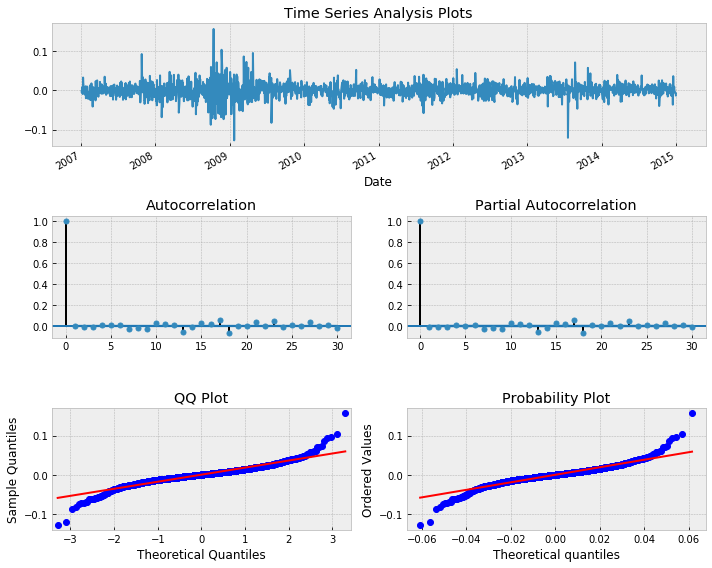

In [18]:
max_lag = 30
Y = lrets.MSFT
mdl = smt.ARMA(Y, order=best_order).fit(maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

# Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

### Differencing can make time series stationary. Order of differencing is d. 

In [19]:
# Fit ARIMA model to MSFT returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        for k in rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.MSFT, order=(i, j, k)).fit(
                    method='mle', trend='nc'
                )
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j, k)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: -10441.16050 | order: (4, 0, 4)


# Now we attempt to forecast

In [20]:
rng = lrets.index
rng.strftime('%Y-%m-%d').astype(str)


Index(['2007-01-04', '2007-01-05', '2007-01-08', '2007-01-09', '2007-01-10',
       '2007-01-11', '2007-01-12', '2007-01-16', '2007-01-17', '2007-01-18',
       ...
       '2014-12-17', '2014-12-18', '2014-12-19', '2014-12-22', '2014-12-23',
       '2014-12-24', '2014-12-26', '2014-12-29', '2014-12-30', '2014-12-31'],
      dtype='object', length=2013)

In [21]:
lrets.reset_index(inplace = True)


In [22]:
lrets.index = rng.strftime('%Y-%m-%d').astype(str)
lrets.head()

,Date,AAPL,MSFT,SPY
2007-01-04,2007-01-04,0.021953,-0.001676,0.002120
2007-01-05,2007-01-05,-0.007147,-0.005719,-0.008008
2007-01-08,2007-01-08,0.004926,0.009737,0.004614
2007-01-09,2007-01-09,0.079800,0.001002,-0.000850
2007-01-10,2007-01-10,0.046746,-0.010064,0.003326


In [23]:
lrets.shape

(2013, 4)

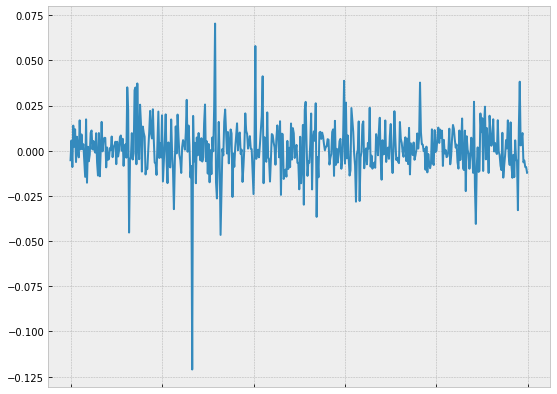

In [24]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.MSFT.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')


 

In [25]:
# in sample prediction

pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.MSFT.iloc[-500:].copy()
ts.plot(  label='MSFT Returns')
# in sample prediction


fc_all.plot(  style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

# Autoregressive Conditionally Heteroskedastic Models - ARCH(p)


$Var(y_t | y_{t-1}) = σ_t^2 = α_0 + α_1 y_{t-1}^2$

$y_t = \sigma_t \epsilon_t = \sqrt{\alpha_0 + \alpha_1 y_{t-1}^2}, ϵ_t \sim \mathbb{N}(0,1)$

In [26]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.MSFT.loc['2012':'2015']
best_aic, best_order, best_mdl = _get_best_model(TS)


aic: -4324.41817 | order: (4, 0, 1)


In [27]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

p_

4

In [28]:
# Using student T distribution usually provides better fit
am = arch_model(TS, p=4, o=0, q=1, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         MSFT   R-squared:                      -0.010
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.010
Vol Model:                            GARCH   Log-Likelihood:                1608.69
Distribution:      Standardized Student's t   AIC:                          -3201.37
Method:                  Maximum Likelihood   BIC:                          -3164.37
                                              No. Observations:                  754
Date:                      Tue, Oct 09 2018   Df Residuals:                      746
Time:                              13:15:15   Df Model:                            8
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

/home/nilavro/anaconda3/envs/py35/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [29]:
from statsmodels.stats.diagnostic import het_breushpagan


residuals = res.resid 

xs = np.arange(len(residuals))
xs_with_constant = sm.add_constant(xs)
_, pvalue1, _, _ =  het_breushpagan(residuals.values, xs_with_constant)
pvalue1

0.6923921328438324

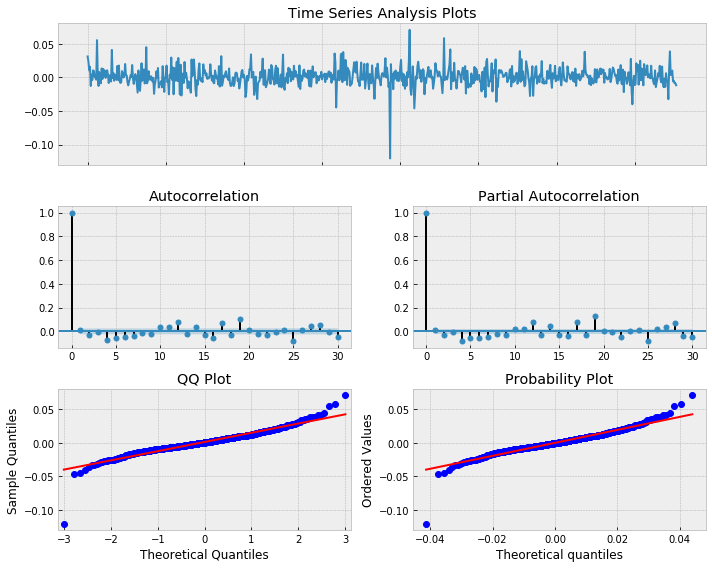

In [30]:
_ = tsplot(res.resid, lags=30)

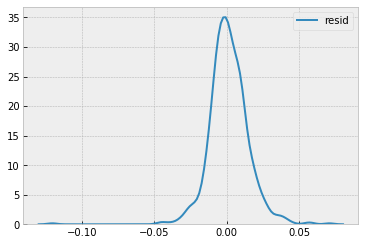

In [31]:
sns.kdeplot(res.resid)

# Normality Test

In [33]:
from statsmodels.stats.stattools import jarque_bera 
from statsmodels.stats.diagnostic import kstest_normal


N = 1000
M = 1000

pvalues = np.ndarray((N))

for i in range(N):
    # Draw M samples from a normal distribution 
    X = np.random.normal(0, 1, M);
    _, pvalue, _, _ = jarque_bera(X)
    pvalues[i] = pvalue
    
# count number of pvalues below our default 0.05 cutoff
num_significant = len(pvalues[pvalues < 0.05])

print( (num_significant) / N)

0.04


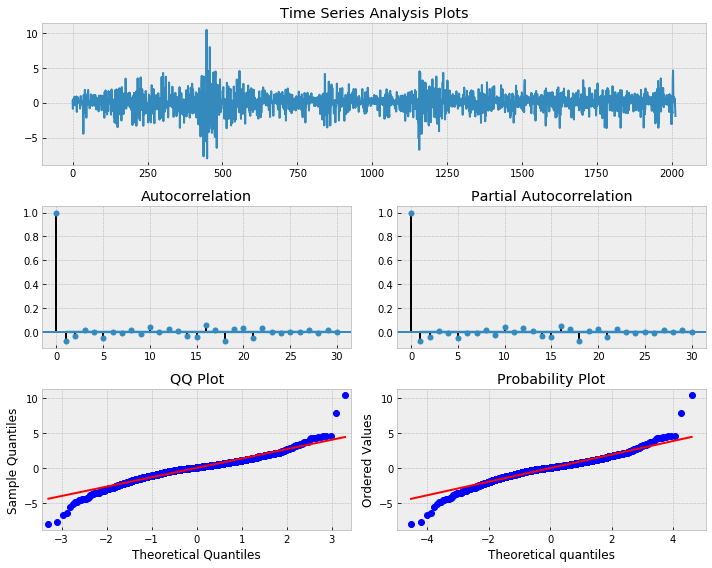

In [34]:
_ = tsplot(np.diff(data.SPY), lags=30)

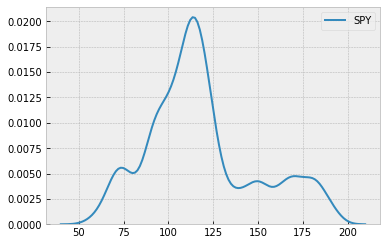

In [35]:
sns.kdeplot((data.SPY))

In [36]:
_, pvalue, _, _ =  jarque_bera((lrets.SPY))
print (pvalue)

0.0


# STL Decomposition

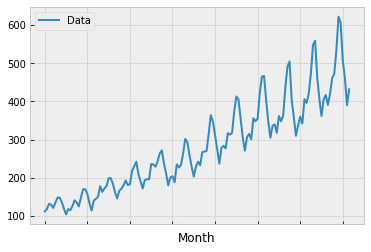

In [37]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

series = pd.read_csv('international-airline-passengers.csv', parse_dates=True)
series.set_index('Month', inplace=True)
series.plot()
pyplot.show()



In [38]:
series.head()

,Data
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


## Additive Models

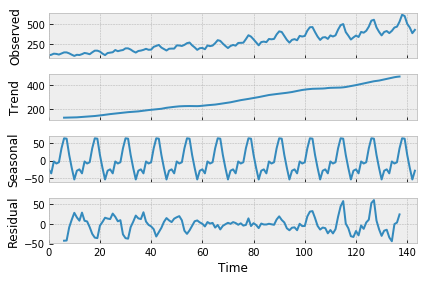

In [39]:
decomposed =  seasonal_decompose(series.values, freq=12)

decomposed.plot()
pyplot.show()

## Multiplicative Models

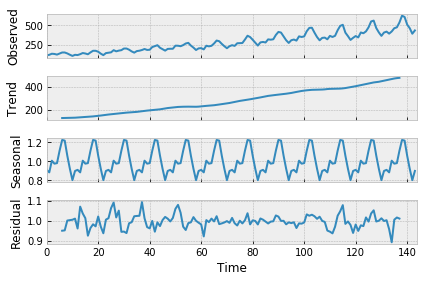

In [40]:
decomposed =  seasonal_decompose(series.values, freq=12, model='multiplicative')

decomposed.plot()
pyplot.show()

# Naive Decomposition

The additive model is Y[t] = T[t] + S[t] + e[t]

The multiplicative model is Y[t] = T[t] * S[t] * e[t]

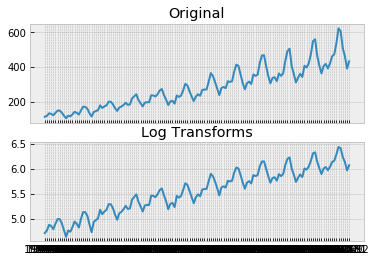

In [41]:
from sklearn import linear_model


ts_log = np.log(series)

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(series)
axarr[0].set_title('Original')
axarr[1].set_title('Log Transforms')
axarr[1].plot(ts_log)

In [42]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [43]:
from scipy.optimize import curve_fit

xdata = np.linspace(1, series.shape[0], series.shape[0])
ydata = series.values.reshape(series.shape[0]) 

popt, pcov = curve_fit(func, xdata, ydata)

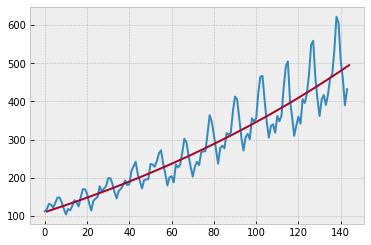

In [44]:
plt.plot(ydata)
plt.plot(xdata, func(xdata, *popt))

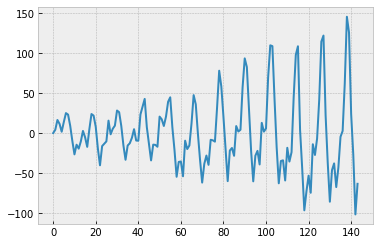

In [45]:
detrend = ydata - func(xdata, *popt)

plt.plot(detrend)

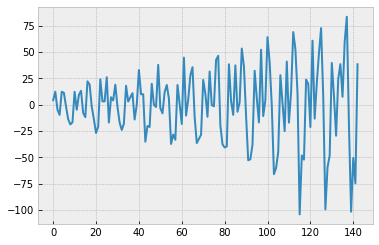

In [46]:
plt.plot( np.diff(detrend))

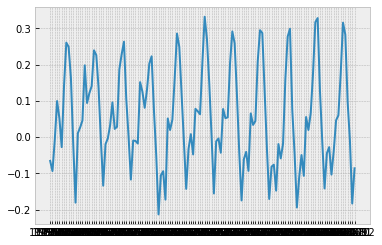

In [47]:
moving_avg = ts_log.rolling(12).mean()
ts_log_moving_avg_diff = ts_log - moving_avg

ts_log_moving_avg_diff.dropna(inplace=True)

ts_log_moving_avg_diff.dropna(inplace=True)

plt.plot(ts_log_moving_avg_diff)

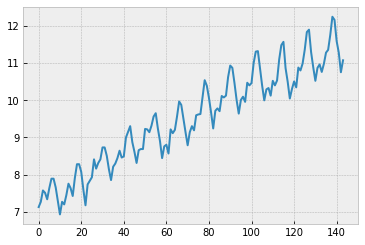

In [48]:
from scipy.stats import boxcox

boxcox, maxlog = (boxcox(ts_log))
plt.plot(boxcox)

## Detrend Linear

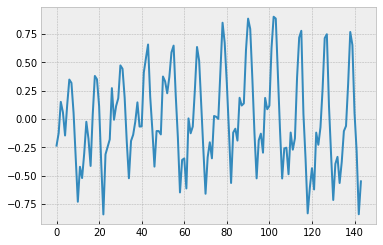

In [49]:
from scipy.optimize import curve_fit

import scipy 

xdata = np.linspace(1, series.shape[0], series.shape[0])
ydata = boxcox.reshape(boxcox.shape[0])

plt.plot(scipy.signal.detrend(ydata))

# Detrend Polynomial

In [50]:
def func(x, a, b, c):
    return a * x**2 + b *x  + c

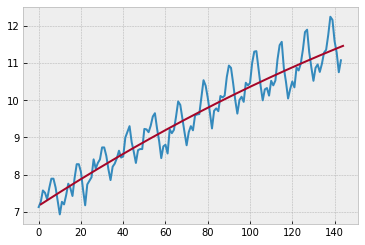

In [51]:
from scipy.optimize import curve_fit

import scipy 

xdata = np.linspace(1, series.shape[0], series.shape[0])
ydata = boxcox.reshape(boxcox.shape[0])

xdata = np.linspace(1, series.shape[0], series.shape[0])
 
popt, pcov = curve_fit(func, xdata, ydata)

plt.plot(ydata)
plt.plot(xdata, func(xdata, *popt))

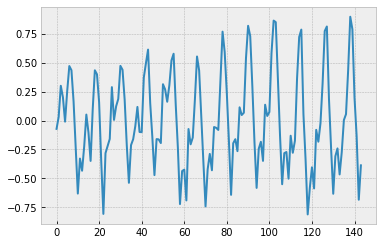

In [52]:
detrendBoxCox = ydata - func(xdata, *popt)
plt.plot(detrendBoxCox)

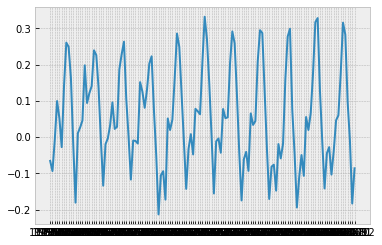

In [53]:
plt.plot( ts_log_moving_avg_diff)
  

# Testing SARIMA Models

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


tmp_mdl = SARIMAX(ts_log_moving_avg_diff.values.reshape(-1,1), order=(1, 0, 1), seasonal_order=(1, 0, 1, 12) ).fit(method='lbfgs' )

In [55]:
rng = range(3) # [0,1,2,3,4,5]
rng

range(0, 3)

In [56]:
# Fit SARIMA model to MSFT returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(3) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        for k in rng:
            for p in rng:
                for d in rng:
                    for q in rng:
                        try:
                            tmp_mdl = SARIMAX(ts_log_moving_avg_diff.values.reshape(-1,1), order=(i, j , k), seasonal_order=(p, d, q, 12) ).fit(method='lbfgs' )
                            tmp_aic = tmp_mdl.aic
                            if tmp_aic < best_aic:
                                best_aic = tmp_aic
                                best_order = (i, j, k, p, d, q)
                                best_mdl = tmp_mdl
                            print(i, j, k, p, d, q, tmp_aic)
                        except: continue

0 0 0 0 0 0 -133.69772233675408
0 0 0 0 1 0 -363.7041188116955
0 0 0 0 2 0 -208.36064234791618
0 0 0 0 0 1 -224.64309796725826
0 0 0 0 1 1 -403.4958956959868
0 0 0 0 1 2 -402.81615853226594
0 0 0 1 0 0 -377.9434201298326
0 0 0 1 1 0 -394.68072573720025
0 0 0 1 2 0 -270.75220379565104
0 0 0 1 0 1 -414.12927735838315
0 0 0 1 1 1 -402.60956300088463
0 0 0 1 2 1 -309.6073873262808
0 0 0 1 1 2 -404.4163114988541
0 0 0 2 0 0 -406.32304433923275
0 0 0 2 1 0 -396.3165110760658
0 0 0 2 2 0 -275.93478035387074
0 0 0 2 1 1 -400.61439979069337
0 0 0 2 2 1 -309.94233894018845
0 0 0 2 1 2 -402.5676698459506
0 0 1 0 1 0 -398.9796847885097
0 0 1 0 2 0 -245.5811273137744
0 0 1 0 1 1 -436.31315781284576
0 0 1 0 1 2 -434.9644631992038
0 0 1 1 1 0 -425.9160582613622
0 0 1 1 2 0 -299.88863554003893
0 0 1 1 1 1 -434.873094851491
0 0 1 1 2 1 -337.57063467590893
0 0 1 1 1 2 -434.514580725506
0 0 1 2 1 0 -428.83701006827886
0 0 1 2 2 0 -308.5149446395235
0 0 1 2 1 1 -432.92885250303897
0 0 1 2 2 1 -338.7064048

1 1 0 0 0 1 -306.9729007158863
1 1 0 0 1 1 -443.1931315419038
1 1 0 0 2 1 -342.9640362713082
1 1 0 0 1 2 -441.27629641208955
1 1 0 0 2 2 -358.77676537984354
1 1 0 1 0 0 -438.79658938621975
1 1 0 1 1 0 -438.9927967041913
1 1 0 1 2 0 -323.310548863743
1 1 0 1 0 1 -458.9624276501721
1 1 0 1 1 1 -441.27702030385024
1 1 0 1 2 1 -354.41378212943016
1 1 0 1 0 2 -457.02423107241066
1 1 0 1 1 2 -439.2762659369465
1 1 0 1 2 2 -357.4167741049307
1 1 0 2 0 0 -454.6223270108885
1 1 0 2 1 0 -439.8236464481606
1 1 0 2 2 0 -336.0643384600076
1 1 0 2 0 1 -456.2038202789728
1 1 0 2 1 1 -439.27957613808786
1 1 0 2 2 1 -354.3781341977728
1 1 0 2 0 2 -455.0373842627479
1 1 0 2 1 2 -421.76742984596336
1 1 0 2 2 2 -351.27843810878994
1 1 1 0 0 0 -226.86107564385145
1 1 1 0 1 0 -420.3242501852309
1 1 1 0 2 0 -278.57880586345124
1 1 1 0 0 1 -305.28561157508165
1 1 1 0 1 1 -446.4318129674639
1 1 1 0 2 1 -341.7934153320284
1 1 1 0 1 2 -442.1970124585971
1 1 1 0 2 2 -359.0728167500713
1 1 1 1 0 0 -437.37636678001

2 2 0 0 2 1 -292.481659167246
2 2 0 0 0 2 -289.500652586315
2 2 0 0 1 2 -385.1891775454736
2 2 0 1 0 0 -379.0896326382471
2 2 0 1 1 0 nan
2 2 0 1 2 0 -270.228602239819
2 2 0 1 0 1 -399.30897386632137
2 2 0 1 1 1 -385.1857844237547
2 2 0 1 2 1 -300.87638697752027
2 2 0 1 0 2 -397.3240674966139
2 2 0 1 1 2 -383.1826969216069
2 2 0 2 0 0 -392.7157167016184
2 2 0 2 1 0 -383.85756228177735
2 2 0 2 2 0 -284.745896361544
2 2 0 2 0 1 -397.32208782368605
2 2 0 2 1 1 -383.2853888761004
2 2 0 2 2 1 -301.76512122377255
2 2 0 2 0 2 -395.3157823489184
2 2 0 2 1 2 -381.3120388611921
2 2 1 0 0 0 -210.41448975420028
2 2 1 0 0 1 -293.74331735413983
2 2 1 0 0 2 -333.49287693183055
2 2 1 1 0 0 -429.3210556194849
2 2 1 1 0 1 -449.15259417096047
2 2 1 1 0 2 -447.0872417315388
2 2 1 2 0 0 -442.49023558593564
2 2 1 2 0 1 -447.3633838398107
2 2 1 2 0 2 -444.0242591189281
2 2 2 0 0 0 -215.64146824535555
2 2 2 0 2 0 -265.99613350558366
2 2 2 0 0 1 -292.33081609609167
2 2 2 0 2 1 -326.1387161946867
2 2 2 0 0 2 -3

In [58]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -477.71467 | order: (1, 0, 0, 1, 0, 1)


In [112]:
model_fit = SARIMAX(ts_log_moving_avg_diff, order=(1, 0, 0), seasonal_order=(1, 0, 1, 12) ).fit(method='lbfgs')
step = 24
forecast = model_fit.forecast(steps = step) 

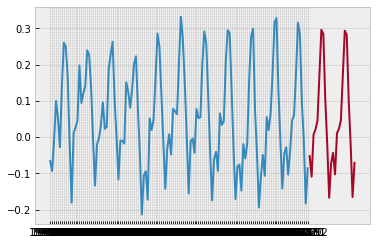

In [114]:
plt.plot(ts_log_moving_avg_diff)
plt.plot(range(ts_log_moving_avg_diff.values.shape[0] ,(ts_log_moving_avg_diff.values.shape[0]+step)), forecast)

In [91]:
model_fit = SARIMAX(detrendBoxCox.reshape(-1,1), order=(1, 0, 0), seasonal_order=(1, 0, 1, 12) , enforce_stationarity=False ).fit(method='lbfgs')

step = 12
forecast = model_fit.forecast(steps = step) 

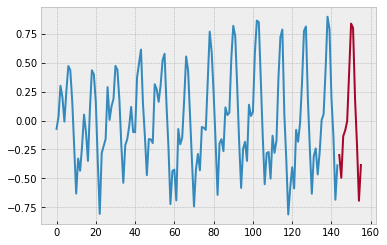

In [92]:
plt.plot(detrendBoxCox.reshape(-1,1))
plt.plot(range(detrendBoxCox.shape[0] ,(detrendBoxCox.shape[0]+step)), forecast)

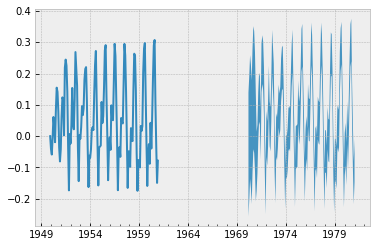

In [134]:
start = '1961-1'
stop = '1961-12'
forecast = model_fit.get_forecast(12)
predict = model_fit.get_prediction()
predict.predicted_mean.plot()

predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
plt.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.9)




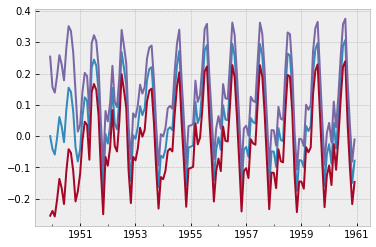

In [148]:
predict.predicted_mean.plot()

predict_ci['lower Data'].plot()
predict_ci['upper Data'].plot()


In [143]:
predict_ci.head()

,lower Data,upper Data
1949-12-01,-0.254356,0.254356
1950-01-01,-0.239039,0.156746
1950-02-01,-0.256634,0.139146
1950-03-01,-0.203146,0.192620
1950-04-01,-0.136597,0.259136


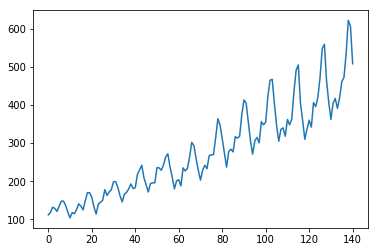

In [2]:
import pandas
import matplotlib.pyplot as plt

%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

94 47
Epoch 1/200
 - 0s - loss: 47088.9472
Epoch 2/200
 - 0s - loss: 41556.4842
Epoch 3/200
 - 0s - loss: 35887.6933
Epoch 4/200
 - 0s - loss: 30116.6553
Epoch 5/200
 - 0s - loss: 24289.2217
Epoch 6/200
 - 0s - loss: 18792.1197
Epoch 7/200
 - 0s - loss: 13786.9119
Epoch 8/200
 - 0s - loss: 9611.5192
Epoch 9/200
 - 0s - loss: 6344.5067
Epoch 10/200
 - 0s - loss: 3976.1873
Epoch 11/200
 - 0s - loss: 2424.7171
Epoch 12/200
 - 0s - loss: 1498.5233
Epoch 13/200
 - 0s - loss: 969.1536
Epoch 14/200
 - 0s - loss: 706.5006
Epoch 15/200
 - 0s - loss: 586.3599
Epoch 16/200
 - 0s - loss: 536.8267
Epoch 17/200
 - 0s - loss: 515.3992
Epoch 18/200
 - 0s - loss: 509.3226
Epoch 19/200
 - 0s - loss: 508.1888
Epoch 20/200
 - 0s - loss: 507.2066
Epoch 21/200
 - 0s - loss: 506.1288
Epoch 22/200
 - 0s - loss: 505.5810
Epoch 23/200
 - 0s - loss: 507.7903
Epoch 24/200
 - 0s - loss: 508.3780
Epoch 25/200
 - 0s - loss: 505.9815
Epoch 26/200
 - 0s - loss: 508.9322
Epoch 27/200
 - 0s - loss: 507.8860
Epoch 28/200

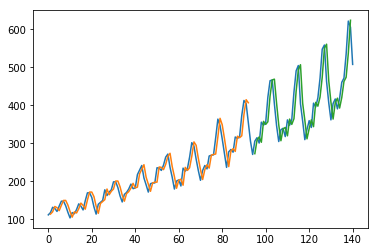

In [19]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t)
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/400
 - 0s - loss: 54478.5981
Epoch 2/400
 - 0s - loss: 34916.4597
Epoch 3/400
 - 0s - loss: 22694.5387
Epoch 4/400
 - 0s - loss: 12395.0272
Epoch 5/400
 - 0s - loss: 5382.3049
Epoch 6/400
 - 0s - loss: 2096.9558
Epoch 7/400
 - 0s - loss: 1084.9645
Epoch 8/400
 - 0s - loss: 943.7162
Epoch 9/400
 - 0s - loss: 923.3543
Epoch 10/400
 - 0s - loss: 910.5870
Epoch 11/400
 - 0s - loss: 912.0308
Epoch 12/400
 - 0s - loss: 919.6416
Epoch 13/400
 - 0s - loss: 904.9393
Epoch 14/400
 - 0s - loss: 900.8697
Epoch 15/400
 - 0s - loss: 909.9991
Epoch 16/400
 - 0s - loss: 912.3083
Epoch 17/400
 - 0s - loss: 906.1600
Epoch 18/400
 - 0s - loss: 904.3408
Epoch 19/400
 - 0s - loss: 906.2829
Epoch 20/400
 - 0s - loss: 921.0799
Epoch 21/400
 - 0s - loss: 901.6320
Epoch 22/400
 - 0s - loss: 885.3829
Epoch 23/400
 - 0s - loss: 897.1849
Epoch 24/400
 - 0s - loss: 899.6734
Epoch 25/400
 - 0s - loss: 899.3097
Epoch 26/400
 - 0s - loss: 908.0988
Epoch 27/400
 - 0s - loss: 891.5896
Epoch 28/400
 - 0s - loss:

 - 0s - loss: 509.8596
Epoch 226/400
 - 0s - loss: 517.6957
Epoch 227/400
 - 0s - loss: 503.8471
Epoch 228/400
 - 0s - loss: 546.1971
Epoch 229/400
 - 0s - loss: 516.8127
Epoch 230/400
 - 0s - loss: 512.0817
Epoch 231/400
 - 0s - loss: 537.9570
Epoch 232/400
 - 0s - loss: 521.8532
Epoch 233/400
 - 0s - loss: 528.5337
Epoch 234/400
 - 0s - loss: 502.4943
Epoch 235/400
 - 0s - loss: 523.1910
Epoch 236/400
 - 0s - loss: 525.9050
Epoch 237/400
 - 0s - loss: 542.3744
Epoch 238/400
 - 0s - loss: 512.4248
Epoch 239/400
 - 0s - loss: 531.7498
Epoch 240/400
 - 0s - loss: 541.6942
Epoch 241/400
 - 0s - loss: 546.7190
Epoch 242/400
 - 0s - loss: 541.1894
Epoch 243/400
 - 0s - loss: 510.2805
Epoch 244/400
 - 0s - loss: 512.3187
Epoch 245/400
 - 0s - loss: 522.5416
Epoch 246/400
 - 0s - loss: 509.4202
Epoch 247/400
 - 0s - loss: 504.9026
Epoch 248/400
 - 0s - loss: 550.2196
Epoch 249/400
 - 0s - loss: 525.3110
Epoch 250/400
 - 0s - loss: 500.6533
Epoch 251/400
 - 0s - loss: 544.3416
Epoch 252/400
 

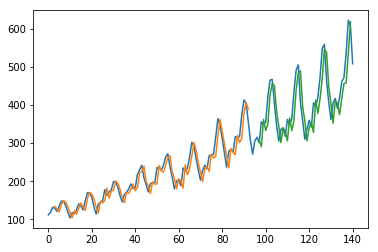

In [20]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t, t-1, t-2)
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()